In [1]:
from __future__ import print_function

import sys
if '/opt/ros/kinetic/lib/python2.7/dist-packages' in sys.path:
    sys.path.remove('/opt/ros/kinetic/lib/python2.7/dist-packages')
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pickle
import scipy.linalg as linalg

import os
import math

%matplotlib inline

In [2]:
# show images
def show_imgs(images, names = None):
    num = len(images)
    if num < 1:
        return
    if num <= 3:
        f, axs = plt.subplots(1, num, figsize=(16, 9))
        f.tight_layout()
        if num == 1:
            axs.imshow(images[0], cmap='gray')
            return
        for i in np.arange(num):            
            axs[i].imshow(images[i], cmap='gray')
            if names is not None:
                axs[i].set_title(names[i], fontsize=16)    
    ## num > 3    
    elif np.mod(num, 2) == 0:
        f, axs = plt.subplots(int(num/2), 2, figsize=(16, 9))
        f.tight_layout()
        for i in np.arange(num):            
            axs[int(i/2), np.mod(i, 2)].imshow(images[i], cmap='gray')
            if names is not None:
                axs[int(i/2), np.mod(i, 2)].set_title(names[i], fontsize=16)
    ##    
    else:
        f, axs = plt.subplots(int((num-1)/3+1), 3, figsize=(16, 9))
        f.tight_layout()
        for i in np.arange(num):
#             print(i)
            axs[int(i/3), np.mod(i, 3)].imshow(images[i], cmap='gray')
            if names is not None:
                axs[int(i/3), np.mod(i, 3)].set_title(names[i], fontsize=15)

### 灰度化

In [3]:
## 
def grayscale(img, type='hsv'):
    img = cv2.resize(img, (int(img.shape[1]/2), int(img.shape[0]/2)))
    if type == 'hsv':
        img_hsv  = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
        img_hsv_gray = cv2.split(img_hsv)[2]
        return img_hsv_gray
    else:
        img_bgr  = cv2.split(img)
        img_gray = 0.5 * img_bgr[1] + 0.5 * img_bgr[2]
        return img_gray

Text(0.5, 1.0, 'H Gray Image')

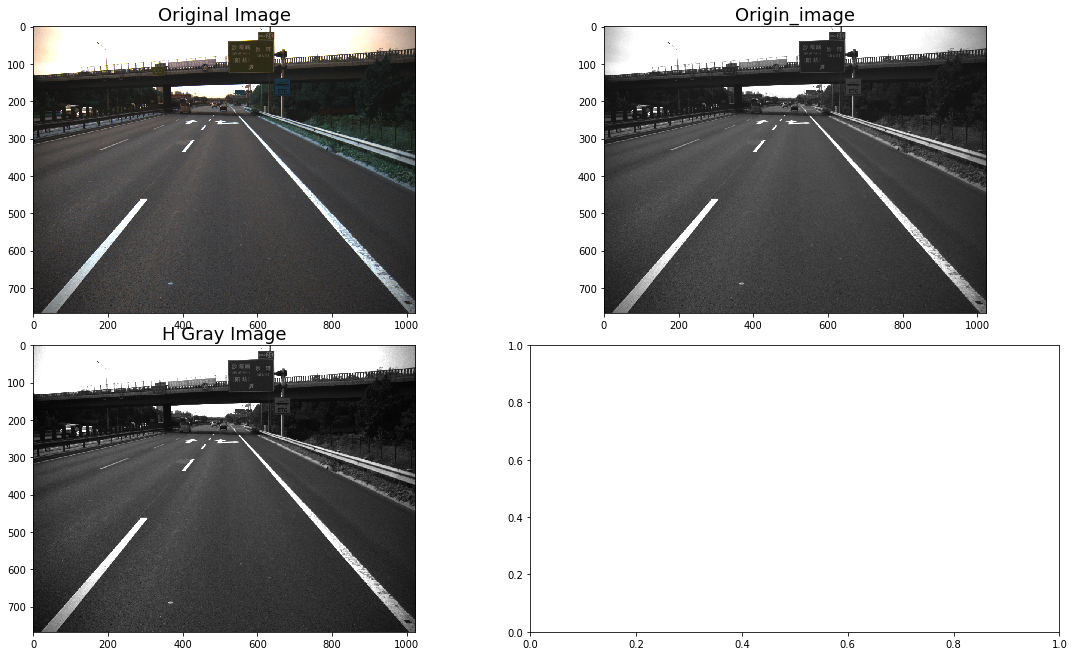

In [4]:
img_path = '/media/andy/DATA1/08_Data/2018-08-16/image/2018-08-16_15-43-13_00006896.bmp'
img_origin = cv2.imread(img_path)
img_hsv  = cv2.cvtColor(img_origin, cv2.COLOR_BGR2HSV)
img_hsv_gray = cv2.split(img_hsv)[2]
img_bgr  = cv2.split(img_origin)
img_gray = 0.5 * img_bgr[1] + 0.5 * img_bgr[2]

f, axs = plt.subplots(2, 2, figsize=(16, 9))
f.tight_layout()
axs[0, 0].imshow(img_origin)
axs[0, 0].set_title('Original Image', fontsize=18)
axs[0, 1].imshow(img_gray, cmap='gray')
axs[0, 1].set_title('Origin_image', fontsize=18)
axs[1, 0].imshow(img_hsv_gray, cmap='gray')
axs[1, 0].set_title('H Gray Image', fontsize=18)


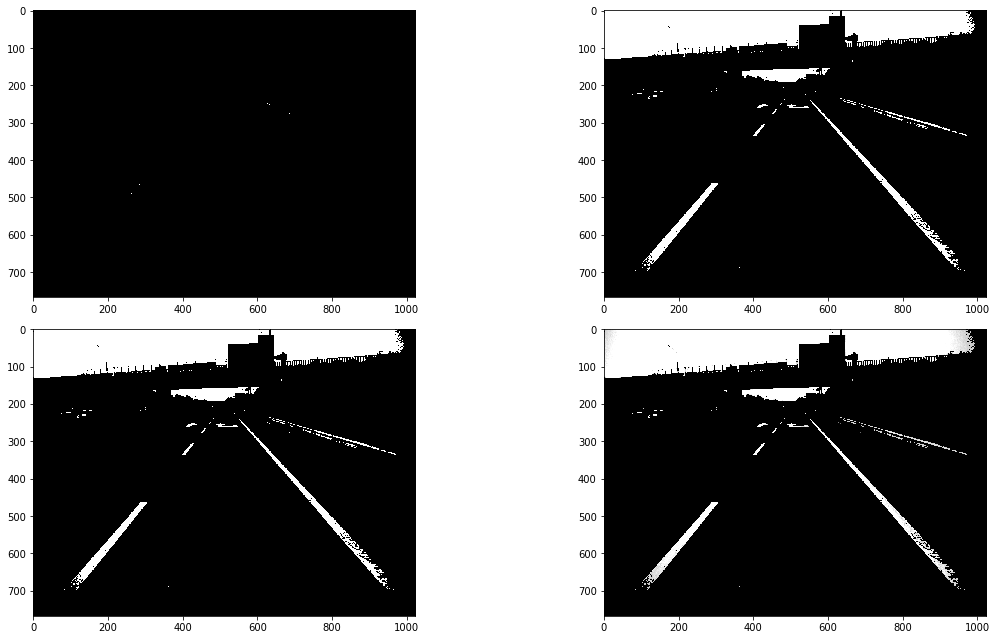

In [19]:
lower_yellow = np.array([20, 100, 100], dtype = 'uint8')
upper_yellow = np.array([30, 255, 255], dtype = 'uint8')
mask_yellow  = cv2.inRange(img_hsv, lower_yellow, upper_yellow)
mask_white   = cv2.inRange(img_hsv_gray, 200, 255)
mask_yw      = cv2.bitwise_or(mask_white, mask_yellow)
mask_yw_image = cv2.bitwise_and(img_hsv_gray, mask_yw)

show_imgs([mask_yellow, mask_white, mask_yw, mask_yw_image])

### Guass Blur and Canny edge

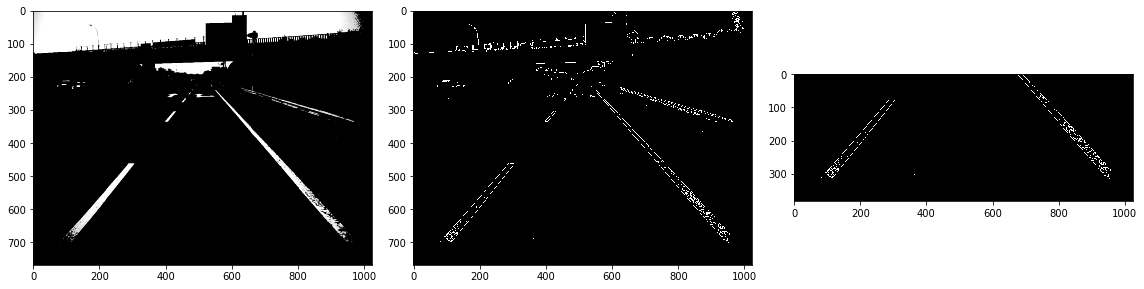

In [32]:
gauss_gray = cv2.GaussianBlur(mask_yw_image, (3,3), 0)
low_threshold = 50
high_threshold = 150
canny_edges = cv2.Canny(gauss_gray,low_threshold,high_threshold)

img_roi = canny_edges[int(canny_edges.shape[0]/2):, :]

show_imgs([gauss_gray, canny_edges, img_roi])

### Hough Lines

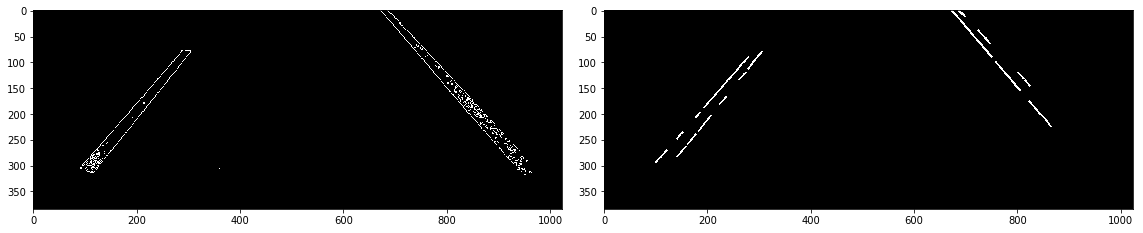

In [44]:
minLineLength = 1000
maxLineGap = 10
lines = cv2.HoughLinesP(img_roi, 5, np.pi / 180, 80, minLineLength, maxLineGap)

img_lines = np.zeros_like(img_roi)
for line in lines:
    for x1, y1, x2, y2 in line:
        cv2.line(img_lines, (x1, y1), (x2, y2), (255,), 2)

show_imgs([img_roi, img_lines])

### Sobel

In [63]:
def sobel_process(img):
    img_gauss = cv2.GaussianBlur(img, (5,5), 0)
    
    img_sobel = cv2.Sobel(img_gauss, cv2.CV_64F, 1, 0, ksize=3)
#     cv2.imshow('sobel', img_sobel)
    img_roi   = img_sobel[int(img_sobel.shape[0]/3):, :]
    img_soble_left = img_roi > 120
    img_soble_right = img_roi < -120
    return img_soble_left, img_soble_right

# img_gauss = cv2.GaussianBlur(img_gray, (3,3), 0)

# img_sobel = cv2.Sobel(img_gray, cv2.CV_64F, 1, 0, ksize=3)
# img_roi   = img_sobel[int(img_sobel.shape[0]/3):, :]

# f, axs = plt.subplots(1, 2, figsize=(16, 9))
# f.tight_layout()
# axs[0].imshow(img_sobel, cmap='gray')
# axs[0].set_title('Sobel Image', fontsize=18)
# axs[1].imshow(img_roi, cmap='gray')
# axs[1].set_title('ROI_image', fontsize=18)

#### Soble 左右

Text(0.5, 1.0, 'Sobel Right')

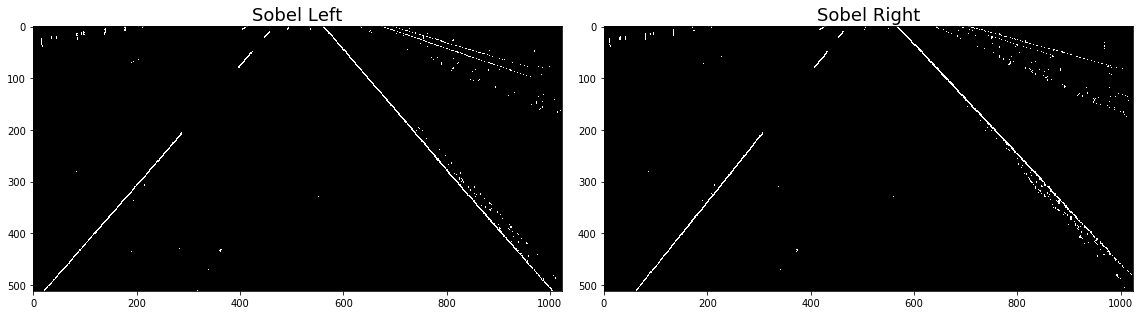

In [51]:
img_soble_left = img_roi > 120
img_soble_right = img_roi < -120

f, axs = plt.subplots(1, 2, figsize=(16, 9))
f.tight_layout()
axs[0].imshow(img_soble_left, cmap='gray')
axs[0].set_title('Sobel Left', fontsize=18)
axs[1].imshow(img_soble_right, cmap='gray')
axs[1].set_title('Sobel Right', fontsize=18)

### 形态学滤波

Text(0.5, 1.0, 'Morph open')

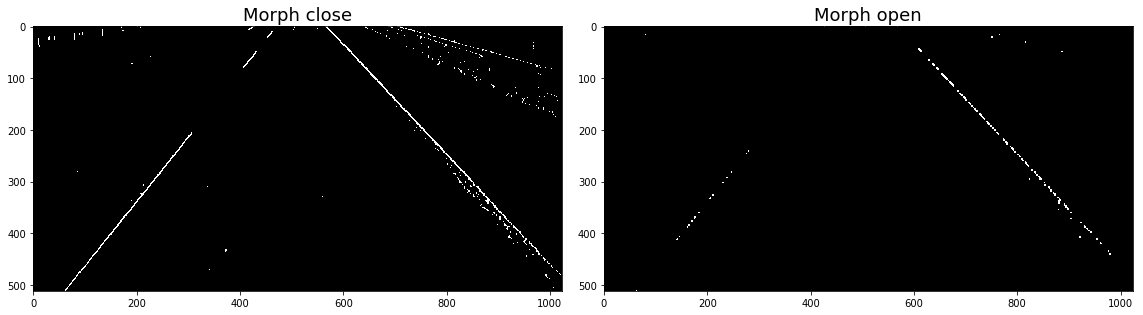

In [54]:
ele = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))
## left
img_soble_left = np.array(img_soble_left, np.uint8)
img_mor = cv2.morphologyEx(img_soble_left, cv2.MORPH_CLOSE, ele)
img_soble_left = np.array(img_soble_left, np.uint8)
img_open = cv2.morphologyEx(img_soble_left, cv2.MORPH_OPEN, ele)

## right
img_soble_right = np.array(img_soble_right, np.uint8)
img_mor = cv2.morphologyEx(img_soble_right, cv2.MORPH_CLOSE, ele)

img_soble_right = np.array(img_soble_right, np.uint8)
img_open = cv2.morphologyEx(img_soble_right, cv2.MORPH_OPEN, ele)

f, axs = plt.subplots(1, 2, figsize=(16, 9))
f.tight_layout()
axs[0].imshow(img_mor, cmap='gray')
axs[0].set_title('Morph close', fontsize=18)
axs[1].imshow(img_open, cmap='gray')
axs[1].set_title('Morph open', fontsize=18)

#### 霍夫变换

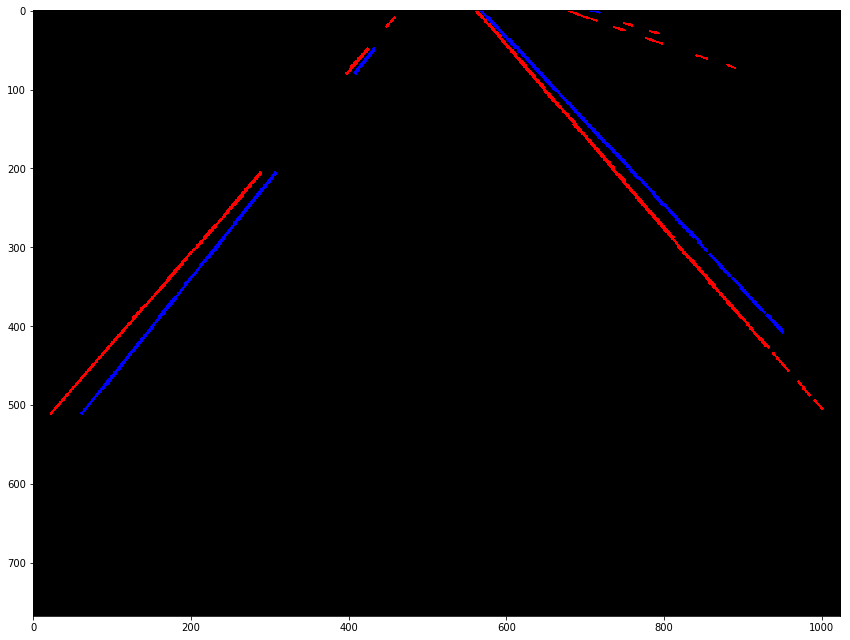

In [59]:
minLineLength = 1000
maxLineGap = 10
lines_left = cv2.HoughLinesP(img_soble_left, 5, np.pi / 180, 80, minLineLength, maxLineGap)
lines_right = cv2.HoughLinesP(img_soble_right, 5, np.pi / 180, 80, minLineLength, maxLineGap)

# img_lines = np.zeros_like(img_mor)
img_lines_c = np.zeros_like(img_origin)
for line in lines_left:
    for x1, y1, x2, y2 in line:
        cv2.line(img_lines_c, (x1, y1), (x2, y2), (255, 0, 0), 2)
for line in lines_right:
    for x1, y1, x2, y2 in line:
        cv2.line(img_lines_c, (x1, y1), (x2, y2), (0, 0, 255), 2)

# print(img_lines)
show_imgs([img_lines_c])

In [66]:
def lines_from_hough(src):
    img_gray = grayscale(src)
#     cv2.imshow('gray', img_gray)
    left, right = sobel_process(img_gray)    
    
#     show_imgs([left, right])
    ele = cv2.getStructuringElement(cv2.MORPH_RECT, (5,5))
    # cvt uint8 and morph
    ## left
    img_soble_left = np.array(left, np.uint8)
    img_soble_left = cv2.morphologyEx(img_soble_left, cv2.MORPH_CLOSE, ele)
#     img_soble_left = np.array(img_soble_left, np.uint8)
#     img_open = cv2.morphologyEx(img_soble_left, cv2.MORPH_OPEN, ele)

    ## right
    img_soble_right = np.array(right, np.uint8)
    img_soble_right = cv2.morphologyEx(img_soble_right, cv2.MORPH_CLOSE, ele)

#     img_soble_right = np.array(img_soble_right, np.uint8)
#     img_open = cv2.morphologyEx(img_soble_right, cv2.MORPH_OPEN, ele)    
    
    minLineLength = 1000
    maxLineGap = 10
    lines_left = cv2.HoughLinesP(img_soble_left, 5, np.pi / 180, 80, minLineLength, maxLineGap)
    lines_right = cv2.HoughLinesP(img_soble_right, 5, np.pi / 180, 80, minLineLength, maxLineGap)

    # img_lines = np.zeros_like(img_mor)
    img_lines_c = np.zeros((left.shape[0], left.shape[1],3), dtype=np.uint8)
    for line in lines_left:
        for x1, y1, x2, y2 in line:
            cv2.line(img_lines_c, (x1, y1), (x2, y2), (255, 0, 0), 2)
    for line in lines_right:
        for x1, y1, x2, y2 in line:
            cv2.line(img_lines_c, (x1, y1), (x2, y2), (0, 0, 255), 2)
    return img_lines_c
#     show_imgs([img_lines_c])
#     print(img_lines_c.shape)

In [72]:
path = '/media/andy/DATA1/08_Data/2018-08-16/image'
# image_list = path + '/image_filelist.txt'
img_name_list = os.listdir(path)
result = None
i = 0
for name in img_name_list:
    i = i+1
    print(i, full_name)
    if i < 50: 
        continue
    if i > 100:
        break
    full_name = os.path.join(path, name)
    img = cv2.imread(full_name)
    if img is None:
        continue
    lc = lines_from_hough(img)
    if result is None:
        result = np.array([lc])
    else:
        result = np.append(result, [lc], axis=0)
#     print(result.shape)    
    cv2.imshow('origin',img)
    cv2.imshow('lines',lc)
    cv2.waitKey()
cv2.destroyAllWindows()
# print(img_origin.shape)
# show_imgs(result)

1 /media/andy/DATA1/08_Data/2018-08-16/image/2018-08-16_15-43-54_00007308.bmp
2 /media/andy/DATA1/08_Data/2018-08-16/image/2018-08-16_15-43-54_00007308.bmp
3 /media/andy/DATA1/08_Data/2018-08-16/image/2018-08-16_15-43-54_00007308.bmp
4 /media/andy/DATA1/08_Data/2018-08-16/image/2018-08-16_15-43-54_00007308.bmp
5 /media/andy/DATA1/08_Data/2018-08-16/image/2018-08-16_15-43-54_00007308.bmp
6 /media/andy/DATA1/08_Data/2018-08-16/image/2018-08-16_15-43-54_00007308.bmp
7 /media/andy/DATA1/08_Data/2018-08-16/image/2018-08-16_15-43-54_00007308.bmp
8 /media/andy/DATA1/08_Data/2018-08-16/image/2018-08-16_15-43-54_00007308.bmp
9 /media/andy/DATA1/08_Data/2018-08-16/image/2018-08-16_15-43-54_00007308.bmp
10 /media/andy/DATA1/08_Data/2018-08-16/image/2018-08-16_15-43-54_00007308.bmp
11 /media/andy/DATA1/08_Data/2018-08-16/image/2018-08-16_15-43-54_00007308.bmp
12 /media/andy/DATA1/08_Data/2018-08-16/image/2018-08-16_15-43-54_00007308.bmp
13 /media/andy/DATA1/08_Data/2018-08-16/image/2018-08-16_15-4

array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)

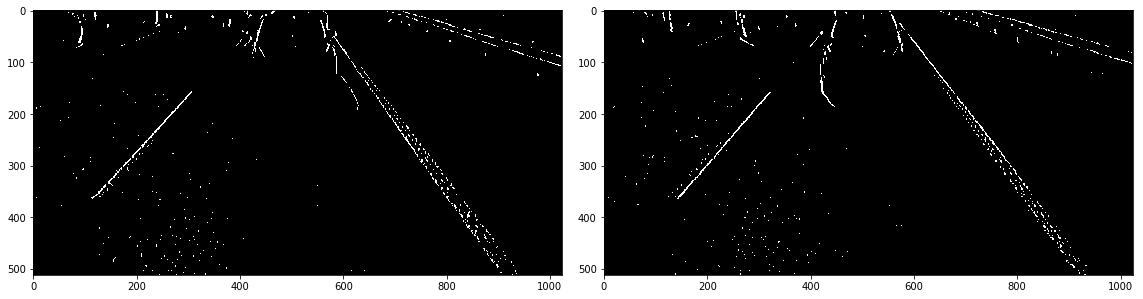

In [45]:
image = cv2.imread('/media/andy/DATA1/08_Data/2018-08-16/image/2018-08-16_15-31-44_00000010.bmp')
lines_from_hough(image)

481.0


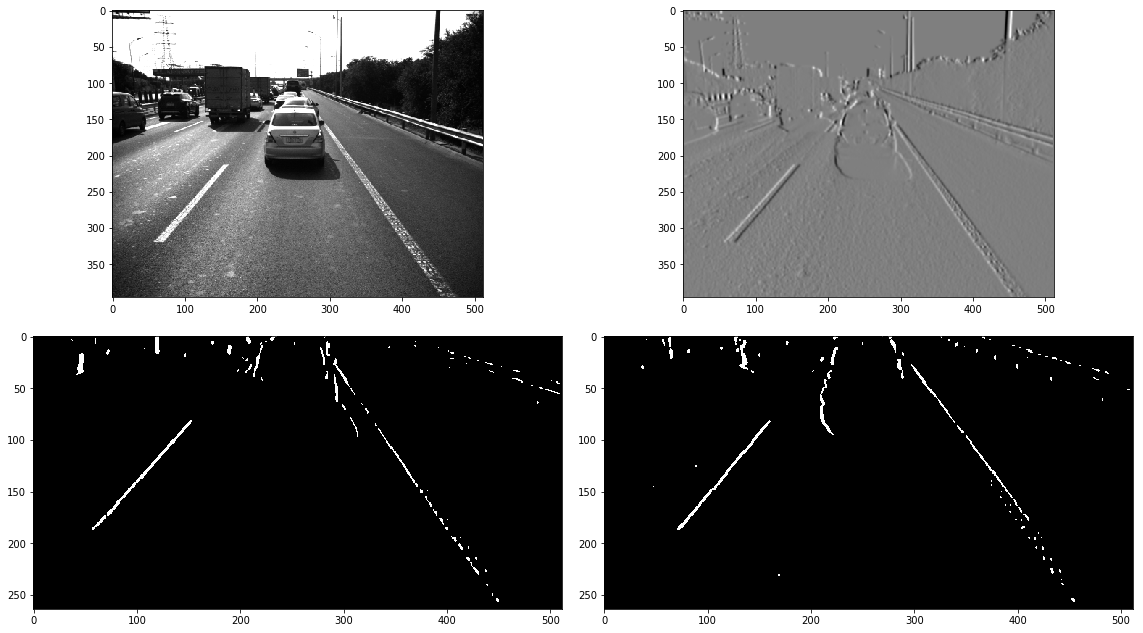

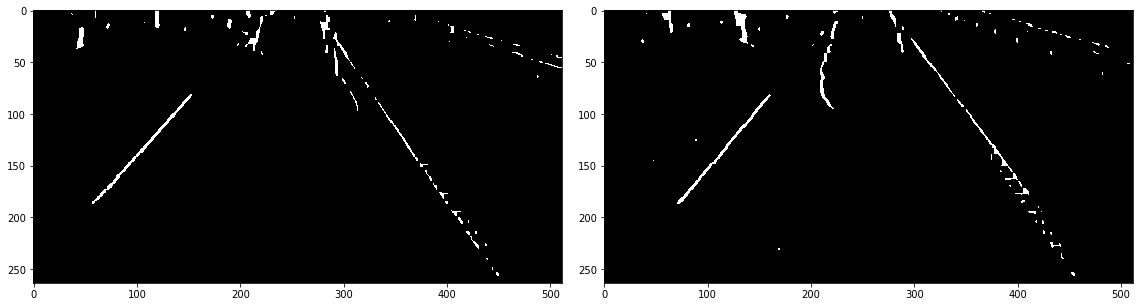

In [62]:
gray = grayscale(image)
gray = cv2.resize(gray, (512,396))

img_gauss = cv2.GaussianBlur(gray, (5,5), 0)

img_sobel = cv2.Sobel(img_gauss, cv2.CV_64F, 1, 0, ksize=3)
#     cv2.imshow('sobel', img_sobel)
img_roi   = img_sobel[int(img_sobel.shape[0]/3):, :]
img_soble_left = img_roi > 130
img_soble_right = img_roi < -130

img_soble_left = np.array(img_soble_left, np.uint8)
img_soble_right = np.array(img_soble_right, np.uint8)
ele = cv2.getStructuringElement(cv2.MORPH_RECT, (5,5))
img_open_l = cv2.morphologyEx(img_soble_left, cv2.MORPH_CLOSE, ele)
img_open_r = cv2.morphologyEx(img_soble_right, cv2.MORPH_CLOSE, ele)


print(np.max(img_roi))
show_imgs([gray, img_sobel, img_soble_left, img_soble_right])
show_imgs([img_open_l, img_open_r])